In [1]:
import time
import pandas as pd
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() # Enable tf v1 behavior as in v2 a lot have changed
import dl_utils as utils
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = pd.read_csv("data/birth_rate.csv")
data.head()

,Country,Birth rate,Life expectancy
0,Vietnam,1.822,74.828244
1,Vanuatu,3.869,70.819488
2,Tonga,3.911,72.150659
3,Timor-Leste,5.578,61.999854
4,Thailand,1.579,73.927659


In [3]:
# Split data/labels
data_X = np.array(data['Birth rate'])
data_Y = np.array(data['Life expectancy'])

In [10]:
# Reshape labels for keras loss compatibility
data_Y = data_Y.reshape(-1, 1)

In [5]:
# Define a path for tensorboard graphs
logdir = './graphs/linear'

In [15]:
## Create placeholders for X, Y
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

In [5]:
## Create weight and bias initialised to 0
w = tf.get_variable('weight', initializer=tf.constant(0.0))
b = tf.get_variable('bias', initializer=tf.constant(0.0))

In [6]:
## Prediction
Y_hat = tf.add(tf.multiply(X,w), b)

In [8]:
## Huber loss as a loss function as and alternative loss
def huber_loss(labels, predictions, delta=14.0):
    residual = tf.abs(labels - predictions)
    def f1(): return 0.5 * tf.square(residual)
    def f2(): return (delta * residual) - (0.5 * tf.square(delta))
    
    return tf.cond(residual < delta, f1, f2)

In [7]:
## Loss Function - MSE 

loss = tf.keras.losses.mean_squared_error(Y,Y_hat)
#loss = huber_loss(Y,Y_hat)

## Define gradient descent as the optimizer to minimise the loss
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [8]:
# Initialise a cpu/gpu session
#sess = tf.Session()

# Initialise a gpu session properly
sess = utils.gpu_session()

### Training with feed_dict

In [11]:
history = []
start = time.time()

# Graph variable initialization
sess.run(tf.global_variables_initializer())

# Open stream for tensorboard
#writer = tf.summary.FileWriter(logdir, sess.graph)

# Start training
for i in range(50):
    total_loss = 0
    
    for x in range(len(data)):
        _, l = sess.run([optimizer,loss], feed_dict={X: data_X[x], Y:data_Y[x]})
        total_loss += l
        
    if (i) % 10 == 0:        
        dw, db = sess.run([w,b])
        y_hat = data_X * dw + db
        history.append(y_hat)
        
        print('Epoch {0}: {1}'.format(i, total_loss/len(data)))
        print('dw: %f, db: %f\n' %(dw, db))   

#writer.close()

print('Train Time: %f seconds' %(time.time() - start))

Epoch 0: 1661.863764550287
dw: 10.362069, db: 8.945575

Epoch 10: 335.55436177954664
dw: 2.944107, db: 43.726894

Epoch 20: 119.20935661137888
dw: -1.186352, db: 62.606369

Epoch 30: 55.77163058824279
dw: -3.432528, db: 72.873177

Epoch 40: 37.305592010505066
dw: -4.654056, db: 78.456520

Train Time: 7.129496 seconds


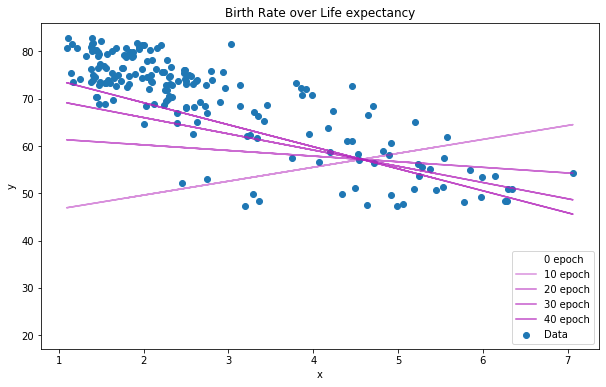

In [13]:
# Plot dataset and fit lines
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

ax.scatter(data_X,data_Y, label="Data")
for i in range(len(history)):
    ax.plot(data_X,history[i], c='#b222ba',label=str(i*10)+" epoch", alpha = i/(i+1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Birth Rate over Life expectancy')
ax.legend()

In [14]:
%load_ext tensorboard

In [15]:
%tensorboard --logdir graphs

### Training with tf.Data
Placeholder and feed_dicts put the data processing outside TF, making it easy to preprocess them but with the tradeoff that it can potentially slow down the program.

In [3]:
# Split data/labels
data_X = np.array(data['Birth rate'])
data_Y = np.array(data['Life expectancy'])

In [4]:
'''
With tf.data insteat of storing the data in non TF objects,
we store it in a tf.data.Dataset object
'''
tf.data.Dataset.from_tensor_slices((data_X,data_Y))

<DatasetV1Adapter shapes: ((), ()), types: (tf.float64, tf.float64)>

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((data_X.astype(np.float32),data_Y.astype(np.float32)))

In [6]:
'''
When the data are in a Dataset object we need to iterate them somehow
Creating an iterator object, and calling get_next() method, 
each time a sample is returned
'''
iterator = dataset.make_initializable_iterator()
X,Y = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [7]:
## Create weight and bias initialised to 0
w = tf.get_variable('weight', initializer=tf.constant(0.0))
b = tf.get_variable('bias', initializer=tf.constant(0.0))

In [8]:
## Prediction
Y_hat = tf.add(tf.multiply(X,w), b)

In [18]:
# Reshape labels for keras loss compatibility
data_Y = data_Y.reshape(-1, 1)

In [15]:
## Loss function using the square error
#loss = tf.square(Y-Y_hat, name='loss')
Y = tf.placeholder(tf.float32, name='Y')
loss = tf.keras.losses.mean_squared_error(Y,Y_hat)
#loss = huber_loss(Y,Y_hat)

## Define gradient descent as the optimizer to minimise the loss
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [16]:
# Initialise a gpu session
sess = utils.gpu_session()

# Initialise a cpu session
#sess = tf.Session()

In [13]:
from tqdm import trange

In [19]:
history = []
start = time.time()

# Graph variable initialization
sess.run(tf.global_variables_initializer())

# Open stream for tensorboard
#writer = tf.summary.FileWriter(logdir, sess.graph)

# Start training
for i in range(50):
    sess.run(iterator.initializer)
    total_loss = 0    
    try:
        while True: 
            _, l = sess.run([optimizer, loss]) 
            total_loss += l
        
    except tf.errors.OutOfRangeError:
        pass

    if (i) % 10 == 0:        
        dw, db = sess.run([w,b])
        y_hat = data_X * dw + db
        history.append(y_hat)
        
        print('Epoch {0}: {1}'.format(i, total_loss/len(data)))
        print('dw: %f, db: %f\n' %(dw, db))   

#writer.close()

print('Train Time: %f seconds' %(time.time() - start))

InvalidArgumentError: You must feed a value for placeholder tensor 'Y' with dtype float
	 [[node Y (defined at /home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]

Original stack trace for 'Y':
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/usr/local/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-7826489aac5c>", line 3, in <module>
    Y = tf.placeholder(tf.float32, name='Y')
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py", line 2630, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6671, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "/home/steve/.virtualenvs/tf2_dev/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()


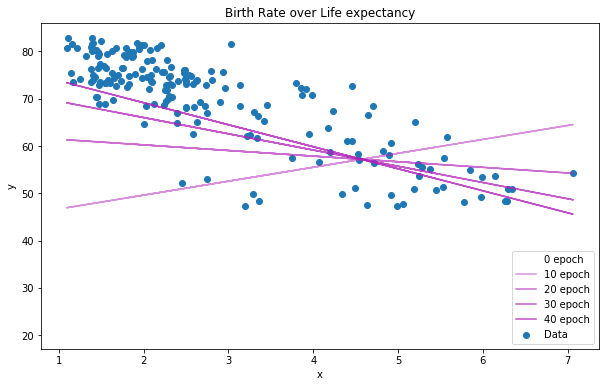

In [15]:
# Plot dataset and fit lines
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

ax.scatter(data_X,data_Y, label="Data")
for i in range(len(history)):
    ax.plot(data_X,history[i], c='#b222ba',label=str(i*10)+" epoch", alpha = i/(i+1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Birth Rate over Life expectancy')
ax.legend()